## Extra notes

https://scikit-learn.org/stable/modules/neural_networks_supervised.html

Hyper parameters for model:
(hidden_layer_sizes: Any = (100, ), activation: str = "relu", *, solver: str = "adam", alpha: float = 0.0001, batch_size: str = "auto", learning_rate: str = "constant", learning_rate_init: float = 0.001, power_t: float = 0.5, max_iter: int = 200, shuffle: bool = True, random_state: Any | None = None, tol: float = 0.0001, verbose: bool = False, warm_start: bool = False, momentum: float = 0.9, nesterovs_momentum: bool = True, early_stopping: bool = False, validation_fraction: float = 0.1, beta_1: float = 0.9, beta_2: float = 0.999, epsilon: float = 1e-8, n_iter_no_change: int = 10, max_fun: int = 15000) -> None

Relevant for project are: alpha, batch_size, learning_rate_init, momentum
max_iter for epoch plot (if using adam solver)
Alpha is for L2 regularization
Might want to change learning_rate from constant

activation functions we use: relu, tanh, logistic (sigmoid)

## Loading libraries

In [1]:
%matplotlib inline
from load_covid_data import load_covid_data
import numpy as np
from sklearn.neural_network import MLPClassifier
from accuracy_score import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
from GridSearch import *
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

## Ignoring convergence warning for not bloating the output

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Loading covid dataset and splitting in train / test

In [3]:

# Loading covid dataset
headers, X, Y = load_covid_data()

n_datapoints = 10000

X = X[: n_datapoints, :] 
Y = Y[: n_datapoints] 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## Training model

In [4]:

layers = [12,10,8]
classifier = MLPClassifier(solver="adam", hidden_layer_sizes=layers, random_state=1, activation="relu")
classifier.fit(X_train, Y_train)

MLPClassifier(hidden_layer_sizes=[12, 10, 8], random_state=1)

Testing model with a prediction

In [5]:
y_pred = classifier.predict(X_test)
print(accuracy_score(y_pred, Y_test))

[[1627  139]
 [  68  166]]
0.8965


## Grid searching on hyperparameters for the MLP on different activation functions

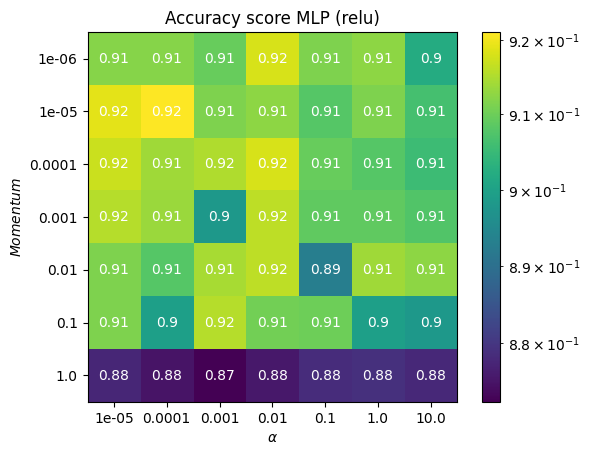

In [6]:
grid_search_hyperparameters_MLP(X_train, X_test, Y_train, Y_test, "Accuracy score MLP (relu)", func="relu", verbose = False)

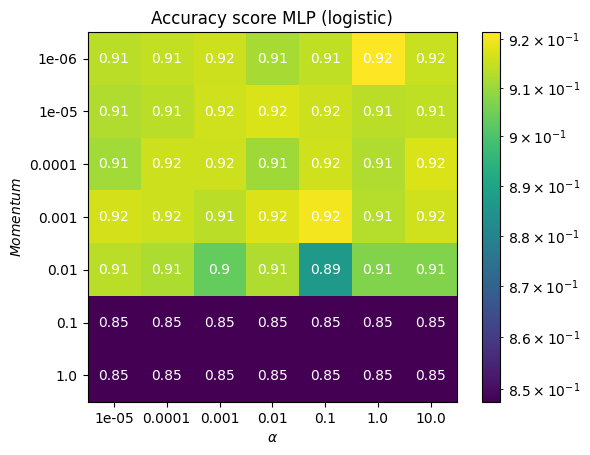

In [7]:
grid_search_hyperparameters_MLP(X_train, X_test, Y_train, Y_test, "Accuracy score MLP (logistic)", func="logistic", verbose = False)

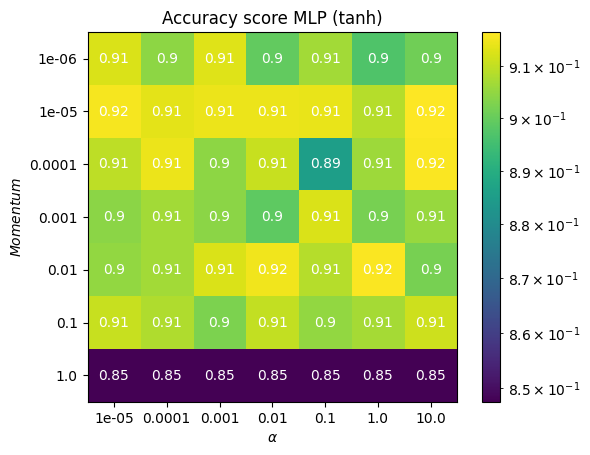

In [8]:
grid_search_hyperparameters_MLP(X_train, X_test, Y_train, Y_test, "Accuracy score MLP (tanh)", func="tanh", verbose = False)

In [9]:
model = MLPClassifier(activation="relu", max_iter=10000)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(accuracy_score(Y_pred, Y_test))

model = MLPClassifier(activation="logistic", max_iter=10000)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(accuracy_score(Y_pred, Y_test))

model = MLPClassifier(activation="tanh", max_iter=10000)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(accuracy_score(Y_pred, Y_test))

[[1627   96]
 [  68  209]]
0.918
[[1651  128]
 [  44  177]]
0.914
[[1620   95]
 [  75  210]]
0.915


## Forest of trees method

In [10]:
forest = RandomForestClassifier(random_state=1)
forest.fit(X_train, Y_train)

RandomForestClassifier(random_state=1)

## Making a prediction with forest of trees method

In [11]:
Y_pred = forest.predict(X_test)
print(accuracy_score(Y_test, Y_pred))
print("predicted chance of dying:",np.sum(Y_pred)/len(Y_pred))
print("Actual chance of dying (test set):",np.sum(Y_test)/len(Y_test))

[[1618   77]
 [ 106  199]]
0.9085
predicted chance of dying: 0.138
Actual chance of dying (test set): 0.1525


## Plotting the feature importances

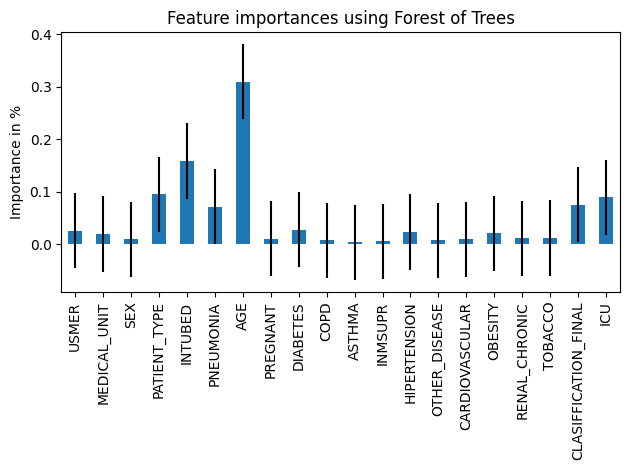

In [12]:

importances = forest.feature_importances_
std = np.std(importances)
forest_importances = pd.Series(importances, index=headers)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Forest of Trees")
ax.set_ylabel("Importance in %")
fig.tight_layout()


## Making histogram of amount of deaths given a certain age

Text(0.5, 0, 'Age')

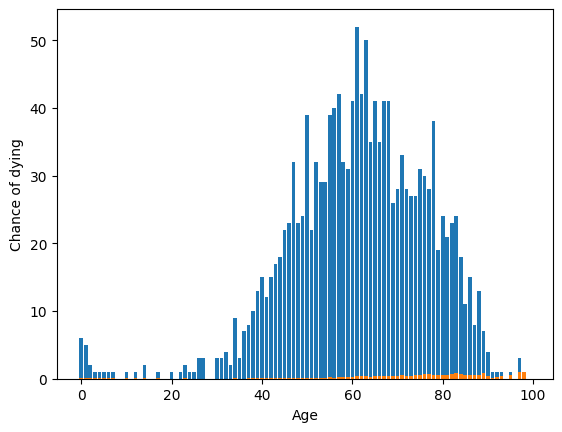

In [13]:
Age = X[:,6]
deaths = {i:0 for i in np.unique(Age)}
for i in range(len(Y)):
    deaths[Age[i]] += Y[i]

plt.bar(range(len(deaths)), list(deaths.values()))
plt.ylabel("Number of deaths")
plt.xlabel("Age")

#Making histogram of chance of dying given a certain age
chance_dying = deaths.copy()
amount = {i:0 for i in np.unique(Age)}

for i in range(len(Y)):
    amount[Age[i]] += 1

for key in chance_dying:
    chance_dying[key] /= amount[key]

plt.bar(range(len(chance_dying)), list(chance_dying.values()))
plt.ylabel("Chance of dying")
plt.xlabel("Age")


## Plotting accuracy score over epoch

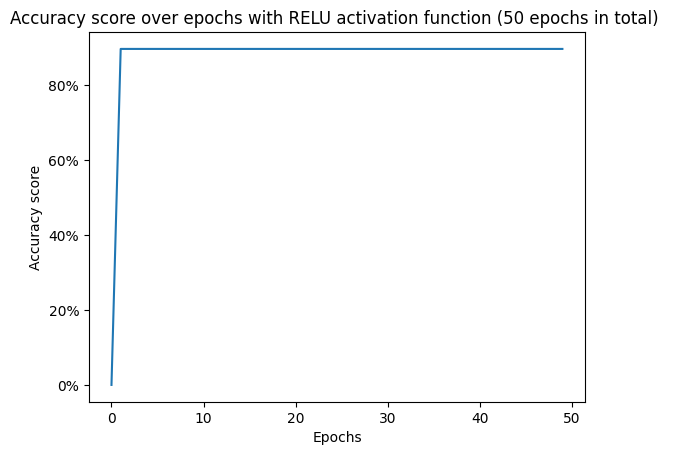

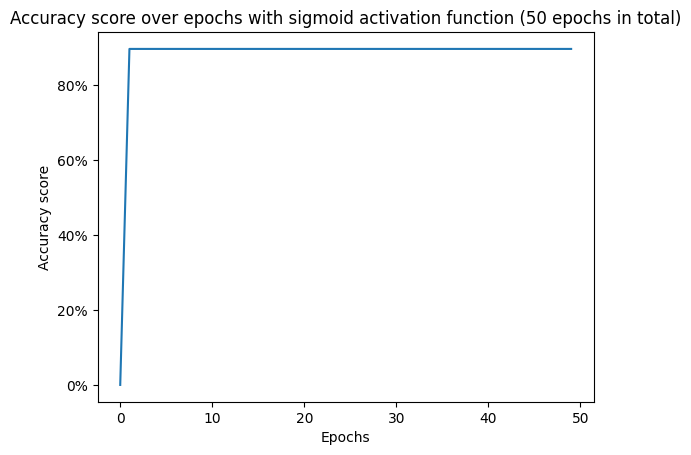

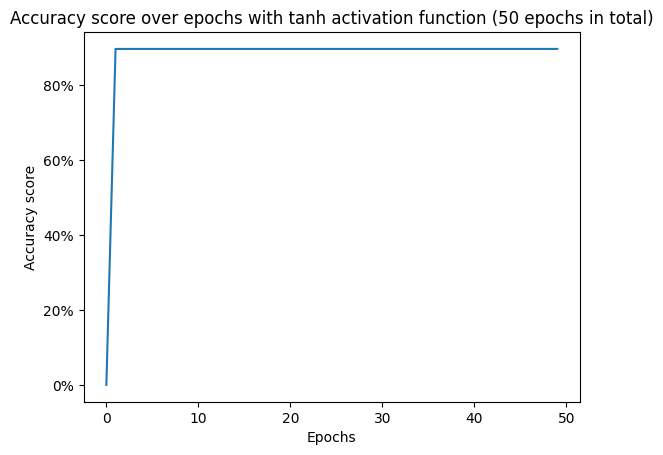

In [14]:
max_epochs = 50

predictions = np.zeros((max_epochs, 3))

for i in range(1, max_epochs):
    classifier_relu = MLPClassifier(solver="adam", hidden_layer_sizes=layers, random_state=1, activation="relu", max_iter = i)
    classifier_relu.fit(X_train, Y_train)
    predictions[i, 0] = accuracy_score(classifier.predict(X_test), Y_test, conf = False)

    classifier_sigmoid = MLPClassifier(solver="adam", hidden_layer_sizes=layers, random_state=1, activation="logistic", max_iter = i)
    classifier_sigmoid.fit(X_train, Y_train)
    predictions[i, 1] = accuracy_score(classifier.predict(X_test), Y_test, conf = False)

    classifier_tanh = MLPClassifier(solver="adam", hidden_layer_sizes=layers, random_state=1, activation="tanh", max_iter = i)
    classifier_tanh.fit(X_train, Y_train)
    predictions[i, 2] = accuracy_score(classifier.predict(X_test), Y_test, conf = False)

# Plotting for relu
plt.figure()
plt.plot(predictions[:, 0] * 100)
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title(f"Accuracy score over epochs with RELU activation function ({max_epochs} epochs in total) ")
plt.savefig("../figures/accuracy_over_epochs_mlp_relu")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

# Plotting for sigmoid
plt.figure()
plt.plot(predictions[:, 1] * 100)
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title(f"Accuracy score over epochs with sigmoid activation function ({max_epochs} epochs in total)")
plt.savefig("../figures/accuracy_over_epochs_mlp_relu")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

# Plotting for tanh
plt.figure()
plt.plot(predictions[:, 2] * 100)
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title(f"Accuracy score over epochs with tanh activation function ({max_epochs} epochs in total)")
plt.savefig("../figures/accuracy_over_epochs_mlp_relu")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

## Looking into chance of dyaing based on age

In [15]:
#Note, not finished, need to figure out way to fix imbalanced data

Age_train = X_train[:,6].reshape(-1,1)
Age_test = X_test[:,6].reshape(-1,1)

model = MLPClassifier(activation="tanh", max_iter=10000)
model.fit(Age_train, Y_train)
YA_pred = model.predict(Age_test)
print(accuracy_score(YA_pred, Y_test))

forestAge = RandomForestClassifier(random_state=1)
forestAge.fit(Age_train, Y_train)

pred = forestAge.predict(Age_test)
accuracy_score(pred, Y_test)

[[1630  220]
 [  65   85]]
0.8575
[[1653  240]
 [  42   65]]


0.859